# Code for the topic modelling

Tuto - https://www.youtube.com/watch?v=arMTVXEbV9Q

## Import packages

In [1]:
# nltk
import nltk
# gensim
import gensim
import gensim.corpora as corpora
# spacy
import spacy
#vis
import pyLDAvis
import pyLDAvis.gensim

In [2]:
import pandas as pd

## Import data

In [3]:
db_init = pd.read_csv("C:/Users/valentin.stuhlfauth/OneDrive - univ-lyon2.fr/2_2025-DUT systematic review/2_Topic modelling/0_code/2025_Pol4PED_systematic_review/0_data/2025-02-27_Screening_result.csv",sep=';',encoding='ISO-8859-1')

In [4]:
db_init["Approach"].unique()

array(['Conceptual', 'Methodological', 'Qualitative', nan, 'Reviews',
       'Quantitative', 'Modelling', 'Ingineering'], dtype=object)

In [5]:
db_init=db_init.reset_index()

In [6]:
data=db_init[db_init["Approach"].isin(['Conceptual', 'Methodological', 'Qualitative'])]

In [7]:
df_text = pd.DataFrame()
df_text["text_topic"] = data["Article Title"] + " " + data["Abstract"]
df_text = df_text["text_topic"]

## Pretreatment

### Lemmatisation, generation and bigrams

In [8]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [9]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

In [10]:
data_words = gen_words(lemmatization(df_text))

In [11]:
#BIGRAMS AND TRIGRAMS
## threshold (float, optional) – Represent a score threshold for forming the phrases (higher means fewer phrases) (init = 100)
bigram_phrases = gensim.models.Phrases(data_words, min_count=100, threshold=1)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=1)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0:3])

[['theory', 'paper_analyze', 'relationship', 'low_carbon_city', 'climate_change', 'background_global', 'warming', 'low_carbon_city', 'construction', 'important', 'measure', 'mitigate_climate_change', 'crisis', 'low_carbon_urban_planning', 'key', 'technology_low_carbon', 'urban_construction', 'research', 'aspect_low_carbon', 'urban_planning', 'theory', 'concept', 'practice', 'low', 'zero', 'carbon', 'community_low_carbon', 'city_development', 'future', 'sum', 'low_carbon_urban_planning', 'research', 'progress', 'domestic', 'overseas', 'put', 'future', 'trend', 'low_carbon_urban_planning', 'research', 'aspect', 'demarcation', 'path_low_carbon', 'city_low_carbon', 'urban_planning', 'construction', 'popularity', 'low_carbon_technology', 'enforcement', 'mechanism', 'innovation', 'low_carbon_city', 'construction'], ['carbon', 'background_global', 'warming', 'energy_crisis', 'low_carbon_economy', 'low_carbon_city', 'gradually', 'call', 'people', 'attention', 'core', 'low_carbon_city', 'econom

### TF-IDF (play with hypervalue)

In [11]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.02
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [95]:
list(dict.fromkeys(words))

['use',
 'urban',
 'base',
 'low_carbon',
 'impact',
 'level',
 'city',
 'study',
 'development',
 'policy',
 'model',
 'analysis',
 'paper',
 'promote',
 'carbon_emission',
 'energy',
 'high',
 'reduce',
 'effect',
 'research',
 'challenge',
 'focus',
 'provide',
 'method',
 'also',
 'find',
 'build',
 'potential',
 'role',
 'affect',
 'approach',
 'goal',
 'need',
 'improve',
 'low_carbon_city',
 'datum',
 'different',
 'result',
 'increase',
 'area',
 'system',
 'low',
 'show',
 'such',
 'carbon',
 'develop',
 'more',
 'important',
 'sustainable',
 'large',
 'design',
 'local',
 'contribute',
 'include',
 'however',
 'apply',
 'emission',
 'consider',
 'construction',
 'analyze',
 'economic',
 'green',
 'strategy',
 'explore',
 'support',
 'evidence',
 'achieve',
 'implementation',
 'result_show',
 'take',
 'evaluate',
 'community',
 'concept',
 'innovation',
 'finally',
 'finding',
 'term',
 'transition',
 'comprehensive',
 'reveal',
 'decrease',
 'value',
 'measure',
 'environment

### Manual Thesaurus

In [84]:
# Stop words 
stop_words=[]
stop_words.append(['CO2'])

print(stop_words)

[['CO2']]


In [85]:
# Stop words suppression 
data_bigrams_trigrams_stop = [[mot for mot in doc if not mot in stop_words] for doc in data_bigrams_trigrams]

## Topic modelling global

### Dictionary

In [12]:
data_bigrams_trigrams = data_words

In [13]:
from gensim.corpora import Dictionary
dico = Dictionary(data_bigrams_trigrams)
print(dico)

Dictionary<5840 unique tokens: ['analyze', 'aspect', 'background', 'carbon', 'change']...>


In [14]:
id2word = corpora.Dictionary(data_bigrams_trigrams)

corpus = []
for text in data_bigrams_trigrams:
    new = id2word.doc2bow(text)
    corpus.append(new)

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[(0, 1), (1, 2), (2, 1), (3, 13), (4, 2), (5, 5), (6, 2), (7, 1), (8, 1), (9, 4), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1)]
analyze


### LDA (init passes=10)

alpha: Controls the sparsity of the document-topic distribution.
- A small alpha will lead to fewer topics being assigned to each document (sparse document-topic distribution).
- A larger alpha will assign more topics to each document (denser document-topic distribution).

beta (or eta): Controls the sparsity of the topic-term distribution.
- A small beta means that topics will have fewer terms associated with them.
- A large beta allows more terms per topic.

BEST:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=25,
                                           #random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha=0.0005,
                                           eta= 0.2)

In [19]:
# lissing topic appartenance = alpha (close to 0 = crisp (binary) / more than 10 = lissing of the results) (deffault = 1/num_topics // "auto")
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=25,
                                           #random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha=0.00005,
                                           eta= 0.01)

In [16]:
lda_model.print_topics()[0]

(3,
 '0.395*"financial" + 0.153*"home" + 0.081*"finance" + 0.071*"support" + 0.021*"abroad" + 0.000*"different" + 0.000*"stage" + 0.000*"low" + 0.000*"city" + 0.000*"include"')

In [17]:
lda_model.show_topic(0)

[('environmental', 0.03516461),
 ('base', 0.03467118),
 ('scenario', 0.030271046),
 ('propose', 0.02963093),
 ('performance', 0.028035942),
 ('method', 0.027645223),
 ('decision', 0.025182812),
 ('study', 0.023721028),
 ('well', 0.022578878),
 ('interaction', 0.020809889)]

### Vizualizing the Data

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.122183 -0.113030       1        1  36.332423
22     0.214171 -0.051272       2        1  16.524799
12     0.142813 -0.312187       3        1   7.843292
18     0.433134  0.070782       4        1   6.036363
21     0.243692 -0.261813       5        1   5.498936
9     -0.034430 -0.270647       6        1   5.211756
10     0.167948 -0.470841       7        1   4.453938
1     -0.217409 -0.228012       8        1   4.328073
0      0.373753 -0.270771       9        1   2.228814
7      0.434734 -0.080998      10        1   2.083824
19     0.412021  0.209052      11        1   1.974492
20     0.303354  0.309242      12        1   1.947964
3     -0.138310 -0.457471      13        1   1.478093
4     -0.437298 -0.206965      14        1   1.158893
16    -0.260140 -0.344655      15        1   1.117911
2     -0.430034  0.275336      16        1   0.574667
6     -0.428631 -0.009246      17        1   0.485324
14     0.119703  0.467529      18        1   0.315311
13    -0.351188  0.146447      19        1   0.184549
23    -0.033412  0.330633      20        1   0.082912
5     -0.153544  0.399140      21        1   0.082804
24    -0.168684  0.240884      22        1   0.054699
8     -0.104809  0.209621      23        1   0.000054
11    -0.104809  0.209621      24        1   0.000054
17    -0.104809  0.209621      25        1   0.000054, topic_info=             Term         Freq        Total Category  logprob  loglift
3          carbon  3948.000000  3948.000000  Default  30.0000  30.0000
20            low  2968.000000  2968.000000  Default  29.0000  29.0000
50         energy  2440.000000  2440.000000  Default  28.0000  28.0000
38          urban  2479.000000  2479.000000  Default  27.0000  27.0000
151        policy  1021.000000  1021.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
9    construction     0.000011   290.798008  Topic25  -8.6725  -2.6534
25          paper     0.000011   791.929279  Topic25  -8.6725  -3.6553
29       practice     0.000011   213.943262  Topic25  -8.6725  -2.3465
33       research     0.000011   580.921581  Topic25  -8.6725  -3.3454
80           then     0.000011   130.800001  Topic25  -8.6725  -1.8545

[1361 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1231      5  1.009951    abandon
426       2  1.010441    ability
1206      9  1.025905      above
340       5  0.947437    absence
193      10  0.986847   academic
...     ...       ...        ...
165       8  0.072601       work
165      10  0.357423       work
166       8  0.310813  worldwide
166      10  0.690695  worldwide
1266     19  0.988651       zone

[1657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 23, 13, 19, 22, 10, 11, 2, 1, 8, 20, 21, 4, 5, 17, 3, 7, 15, 14, 24, 6, 25, 9, 12, 18])

## Data analysis

### Check Topic Distribution per Document

In [197]:
doc_topics = lda_model.get_document_topics(corpus)
print(doc_topics[0])

[(1, 0.8210611), (6, 0.02420239), (11, 0.014071713), (20, 0.14065272)]


### Extract Dominant Topic per Document

In [205]:
def format_topics_documents(lda_model, corpus, texts):
    topics_data = []
    for i, row in enumerate(lda_model[corpus]):  # Get topic distribution for each document
        row = sorted(row, key=lambda x: x[1], reverse=True)  # Sort by topic weight
        if len(row) > 0:
            dominant_topic, prop_topic = row[0]
            topics_data.append((i, dominant_topic, prop_topic, texts[i]))  # Store result
    return topics_data

# Convert df_text to a list
topics_df = pd.DataFrame(format_topics_documents(lda_model, corpus, df_text.tolist()), 
                         columns=["Doc_Index", "Dominant_Topic", "Topic_Percentage", "Text"])

print(topics_df.head())

   Doc_Index  Dominant_Topic  Topic_Percentage  \
0          0               1          0.821038   
1          1               1          0.737688   
2          2               1          0.707698   
3          3              16          0.445549   
4          4               1          0.800450   

                                                Text  
0  The Theory of Practice and Prospect of the Low...  
1  The Application the Concept of Low-carbon in C...  
2  Research on low-carbon cities construction eva...  
3  Smart Cities and Positive Energy Districts: Ur...  
4  Low-Carbon Urban Planning from an Ecosystem Pe...  


### Find Representative Documents for Each Topic

In [199]:
top_docs_per_topic = topics_df.groupby("Dominant_Topic").apply(lambda x: x.nlargest(1, "Topic_Percentage"))
print(top_docs_per_topic[["Dominant_Topic", "Text"]])

c:\Users\valentin.stuhlfauth\AppData\Local\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\valentin.stuhlfauth\AppData\Local\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
c:\Users\valentin.stuhlfauth\AppData\Local\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\valentin.stuhlfauth\AppData\Local\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


NameError: name 'topics_df' is not defined

### Clustering on LDA distribution

Convert Topic Distributions into a Feature Matrix

In [206]:
import numpy as np

# Create a matrix where each row is a document and each column is a topic
def get_document_topic_matrix(lda_model, corpus):
    topic_matrix = []
    for doc in corpus:
        topic_distribution = [0] * lda_model.num_topics  # Initialize with zeros
        for topic_num, prob in lda_model.get_document_topics(doc):
            topic_distribution[topic_num] = prob
        topic_matrix.append(topic_distribution)
    return np.array(topic_matrix)

# Convert corpus to a topic distribution matrix
topic_matrix = get_document_topic_matrix(lda_model, corpus)

Apply Clustering (K-Means)

In [207]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

num_clusters = 5  # Adjust based on coherence scores or trial & error
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(topic_matrix)

# Add cluster labels to the DataFrame
topics_df["Cluster"] = clusters

c:\Users\valentin.stuhlfauth\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Visualize Clusters with PCA

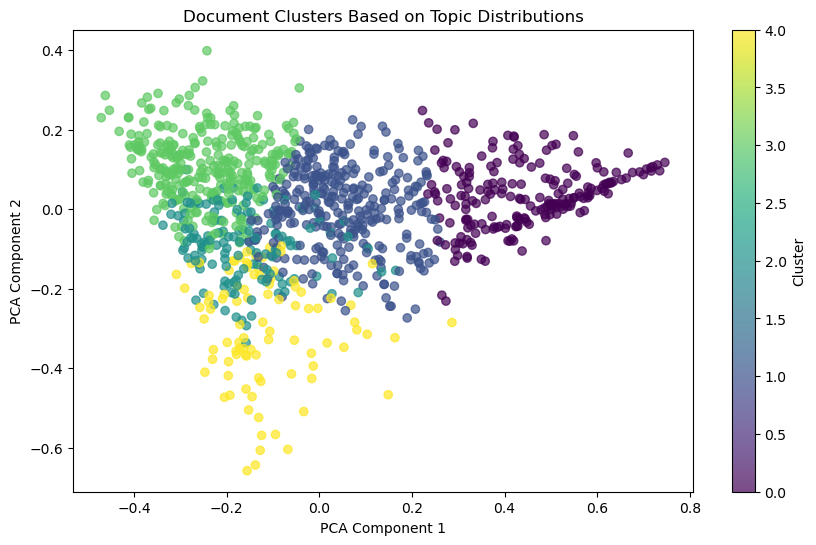

In [208]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
topic_matrix_2D = pca.fit_transform(topic_matrix)

plt.figure(figsize=(10, 6))
plt.scatter(topic_matrix_2D[:, 0], topic_matrix_2D[:, 1], c=clusters, cmap="viridis", alpha=0.7)
plt.colorbar(label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Document Clusters Based on Topic Distributions")
plt.show()

In [191]:
# description of topics' space
doc_topics = lda_model.get_document_topics(corpus[:-1])
print(doc_topics)

In [192]:
# "sparce" matrix transformation
from gensim.matutils import corpus2csc
mat_sparce = corpus2csc(doc_topics)

print(mat_sparce)

  (1, 0)	0.8210985660552979
  (6, 0)	0.024171506986021996
  (11, 0)	0.014071344397962093
  (20, 0)	0.1406465619802475
  (1, 1)	0.7377125024795532
  (3, 1)	0.018623728305101395
  (11, 1)	0.12816067039966583
  (14, 1)	0.0695391595363617
  (20, 1)	0.045946668833494186
  (1, 2)	0.7077450156211853
  (4, 2)	0.22302933037281036
  (10, 2)	0.02164486050605774
  (17, 2)	0.047559790313243866
  (1, 3)	0.15088674426078796
  (7, 3)	0.15146060287952423
  (10, 3)	0.03034970536828041
  (16, 3)	0.44611257314682007
  (21, 3)	0.17799358069896698
  (23, 3)	0.04317309707403183
  (1, 4)	0.8004480600357056
  (11, 4)	0.032552771270275116
  (20, 4)	0.1669830083847046
  (1, 5)	0.42988520860671997
  (4, 5)	0.01709013618528843
  (10, 5)	0.013818930834531784
  :	:
  (11, 1043)	0.07368411123752594
  (13, 1043)	0.05653950572013855
  (16, 1043)	0.3538624942302704
  (17, 1043)	0.010733215138316154
  (20, 1043)	0.04597434401512146
  (23, 1043)	0.057580817490816116
  (24, 1043)	0.026490699499845505
  (1, 1044)	0.19314114

In [193]:
# data frame
mat_dt = mat_sparce.T.toarray()
mat_dt

array([[0.        , 0.82109857, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.7377125 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.70774502, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.26458976, 0.        , ..., 0.        , 0.05758082,
        0.0264907 ],
       [0.        , 0.19314115, 0.        , ..., 0.        , 0.17384699,
        0.04413449],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03697957,
        0.        ]])

In [194]:
# data frame with polarities
dfTopic = pd.DataFrame(mat_dt, columns = ["T" + str(i) for i in range(mat_dt.shape[1])])
df_Topic_treatment = dfTopic
df_Topic_treatment['id'] = db_init['index']

print(df_Topic_treatment.head())

    T0        T1   T2        T3        T4   T5        T6        T7   T8   T9  \
0  0.0  0.821099  0.0  0.000000  0.000000  0.0  0.024172  0.000000  0.0  0.0   
1  0.0  0.737713  0.0  0.018624  0.000000  0.0  0.000000  0.000000  0.0  0.0   
2  0.0  0.707745  0.0  0.000000  0.223029  0.0  0.000000  0.000000  0.0  0.0   
3  0.0  0.150887  0.0  0.000000  0.000000  0.0  0.000000  0.151461  0.0  0.0   
4  0.0  0.800448  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0   

   ...       T16      T17  T18  T19       T20       T21  T22       T23  T24  \
0  ...  0.000000  0.00000  0.0  0.0  0.140647  0.000000  0.0  0.000000  0.0   
1  ...  0.000000  0.00000  0.0  0.0  0.045947  0.000000  0.0  0.000000  0.0   
2  ...  0.000000  0.04756  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0   
3  ...  0.446113  0.00000  0.0  0.0  0.000000  0.177994  0.0  0.043173  0.0   
4  ...  0.000000  0.00000  0.0  0.0  0.166983  0.000000  0.0  0.000000  0.0   

   id  
0   0  
1   1  
2   2  
3   3  
4   